# Moving average trading

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates

import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout
from ipywidgets import HBox, VBox, Label
from ipywidgets import interactive, interactive_output
from ipywidgets import FloatSlider, IntSlider, SelectionSlider, SelectionRangeSlider
from IPython.display import display

import trading as tra
import trading_plots as trp
from trading_defaults import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Default parameters

In [2]:
TICKER     = 'AAPL'
REFRESH    = False # Download fresh Yahoo data 

START_DATE = '2017-07-15'
END_DATE   = '2021-03-22' # make today

### Data download

In [3]:
raw = tra.load_security(dirname = DATA_DIR, 
                        ticker  = TICKER, 
                        refresh = REFRESH, 
                        period  = DEFAULT_PERIOD,
                        )
security = pd.DataFrame(raw[f'Close_{TICKER}'])
security.rename(columns={f'Close_{TICKER}': "Close"},
                inplace=True)

security

Loading data from data/AAPL_5y.pkl


,Close
Date,
2016-03-23,24.6781101
2016-03-24,24.5711479
2016-03-28,24.4595337
2016-03-29,25.0385265
2016-03-30,25.4756794
...,...
2021-03-17,124.7600021
2021-03-18,120.5299988
2021-03-19,119.9899979


#### Setup default start & end dates

In [4]:
# Check dates 
print(tra.get_title_dates(security, START_DATE, END_DATE))
print(tra.get_datetime_dates(security, START_DATE, END_DATE))
print(tra.get_filename_dates(security, START_DATE, END_DATE))

('15-Jul-2017', '22-Mar-2021')
(datetime.datetime(2017, 7, 15, 0, 0), datetime.datetime(2021, 3, 22, 0, 0))
('2017-07-15', '2021-03-22')


## Plotting functions

### Main plotting function

In [5]:
def plot_moving(span, fee_pct, buffer, date_range, reactivity=1):
    '''
    Plots price with moving average
    span -> rolling span
    fee -> fee associated with buy/sell action 
    reactivity -> time lag in days after Close (normally = 1)
    '''
    title_date_format = '%d-%b-%Y'
    start = date_range[0]
    end   = date_range[1]
    start_string = start.strftime('%d-%b-%Y')
    end_string   = end.strftime('%d-%b-%Y')

    # Extract time window
    df = tra.build_strategy(TICKER,
                            security.loc[start:end, :].copy(),
                            span,
                            buffer,
                            INIT_WEALTH,
                           )
    fee  = tra.get_fee(df, fee_pct, ACTIONS)
    hold = tra.get_cumret(df, 'hold')  # cumulative returns for hold strategy
    ema  = tra.get_cumret(df, 'ema', fee)  # cumulative returns for EMA strategy

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(df.index, df.Close, linewidth=1, label='Price')
    ax.plot(df.index, df.EMA, linewidth=1, label=f'{span}-days EMA')

    ax.legend(loc='best')
    ax.set_ylabel('Price ($)')
    ax.xaxis.set_major_formatter(get_year_month_format())
    ax.grid(b=None, which='both', axis='both',
             color=GRID_COLOR, linestyle='-', linewidth=1)

    title  = f'{TICKER} | '
    title += f'{start.strftime(title_date_format)} - {end.strftime(title_date_format)}\n'
    title += f'EMA payoff={ema:.2%} (Hold={hold:.1%}) | '
    title += f'{span}-day rolling mean | {buffer:.2%} buffer'
    ax.set_title(title, fontsize=TITLE_SIZE, color=TITLE_COLOR)

    trp.plot_arrows(ax, df, ACTIONS, get_color_scheme())
    trp.save_figure(PLOT_DIR, f'{TICKER}_{start_string}_{end_string}')
    return df

In [6]:
def plot_span_range(buffer, n_values, fee_pct, date_range):
    trp.plot_span_range(buffer     = buffer, 
                        n_values   = n_values, 
                        fee_pct    = fee_pct, 
                        date_range = date_range, 
                        ticker     = TICKER, 
                        security   = security, 
                       )


max-min ema=2.244226152641604, 1.1405540683795619



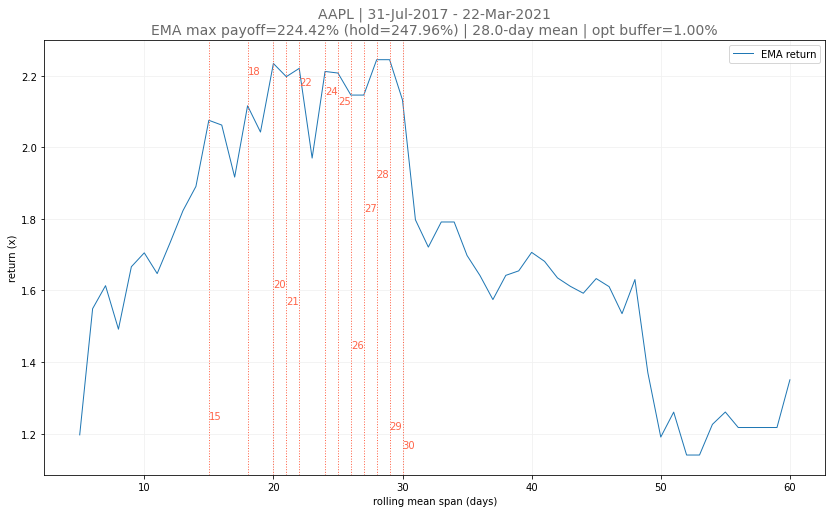

In [7]:
#### test driver for trp.plot_span_range
plot_span_range(buffer     = .01, 
                n_values   = 12, 
                fee_pct    = FEE_PCT, 
                date_range = [datetime.strptime('2017-07-31', '%Y-%m-%d'), 
                              datetime.strptime('2021-03-22', '%Y-%m-%d')], 
               )

In [8]:
def plot_buffer_range(span, n_values, fee_pct, date_range):
    trp.plot_buffer_range(span     = span, 
                          n_values   = n_values, 
                          fee_pct    = fee_pct, 
                          date_range = date_range, 
                          ticker     = TICKER, 
                          security   = security, 
                         )

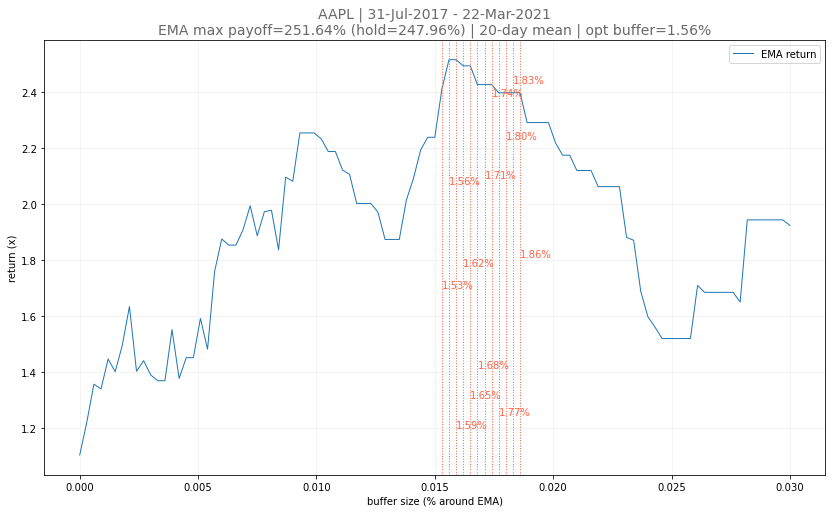

In [9]:
#### test driver for trp.plot_span_range
plot_buffer_range(span     = 20, 
                n_values   = 12, 
                fee_pct    = FEE_PCT, 
                date_range = [datetime.strptime('2017-07-31', '%Y-%m-%d'), 
                              datetime.strptime('2021-03-22', '%Y-%m-%d')], 
               )

Outer Level / 56: 56it [03:31,  3.77s/it]


Max EMA 0=281.20%: 21-days buffer=1.41% (hold=246.03%)
Max EMA 1=264.85%: 21-days buffer=1.38% (hold=246.03%)
Max EMA 2=261.77%: 20-days buffer=1.56% (hold=246.03%)
Max EMA 3=261.77%: 20-days buffer=1.59% (hold=246.03%)
Max EMA 4=261.77%: 21-days buffer=1.53% (hold=246.03%)
Max EMA 5=261.77%: 21-days buffer=1.56% (hold=246.03%)
Max EMA 6=261.77%: 22-days buffer=1.50% (hold=246.03%)
Max EMA 7=260.25%: 22-days buffer=1.53% (hold=246.03%)
Max EMA 8=260.25%: 23-days buffer=1.47% (hold=246.03%)
Max EMA 9=257.83%: 19-days buffer=1.71% (hold=246.03%)


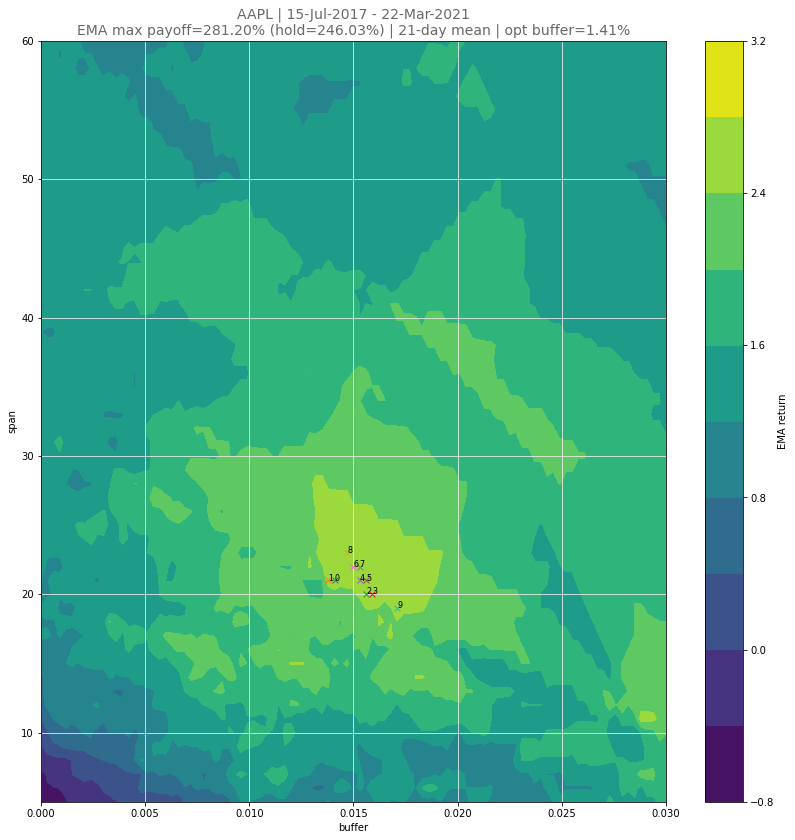

In [10]:
# Contour plot of EMA for all window span/buffer size combinations
def plot_buffer_span_contours():
    '''
    Contour plot of EMA as a function of rolling-window span & buffer
    '''
    fig_size   = (FIG_WIDTH, FIG_WIDTH) # square figure
    n_contours = 10 # number of contours
    n_maxima   = 10 # number of maximum points to plot

    # Get start & end dates in various fomats
    start, end             = tra.get_datetime_dates(security, START_DATE, END_DATE)
    start_title, end_title = tra.get_title_dates(security, START_DATE, END_DATE)
    start_name, end_name   = tra.get_filename_dates(security, START_DATE, END_DATE)
    
    spans, buffers, emas, hold = tra.build_ema_map(TICKER, security, start, end)
    
    # Plot
    fig, ax = plt.subplots(figsize=fig_size)
    plt.contourf(buffers, spans, emas, 
                 levels=n_contours, 
                 cmap='viridis', 
                 )
    plt.colorbar(label='EMA return')
            
    # Plot maxima points 
    max_ema, max_span, max_buff = trp.plot_maxima(emas, 
                                                  spans, 
                                                  buffers, 
                                                  hold, 
                                                  ax, 
                                                  n_maxima)
    
    tra.results_to_file(TICKER, spans, buffers, emas, hold, 30)
        
    # Axis labels
    ax.set_xlabel('buffer')
    ax.set_ylabel('span')
    
    # Build title
    title  = f'{TICKER} | {start_title} - {end_title}\n'
    title += f'EMA max payoff={max_ema:.2%} (hold={hold:.2%}) | '
    title += f'{max_span:.0f}-day mean | '
    title += f'opt buffer={max_buff:.2%}'
    ax.set_title(title, fontsize=TITLE_SIZE, color=TITLE_COLOR)
    
    plt.grid(b=None, which='major', axis='both', color=GRID_COLOR)
    trp.save_figure(PLOT_DIR, f'{TICKER}_{start_name}_{end_name}_contours')
    plt.show()
    
plot_buffer_span_contours()
    

### Interactive plots

#### Widget defaults

In [11]:
string_style = {'description_width': 'initial', 
                'handle_color':      'lawngreen'}

start_period, end_period = tra.get_datetime_dates(security, START_DATE, END_DATE)
dates   = pd.date_range(start_period, end_period, freq='D')
options = [(date.strftime(' %d/%m/%Y'), date) for date in dates]
index   = (0, len(options)-1)

# Tx/broker's fee
min_fee     = 0.0
max_fee     = .01
delta_fee   = .0005
default_fee = FEE_PCT

# of days for running mean
min_span     = MIN_SPAN
max_span     = MAX_SPAN
delta_span   = 1
default_span = 20

# buffer around EMA
min_buffer     = MIN_BUFF
max_buffer     = MAX_BUFF
delta_buffer   = .0001
default_buffer = .01

# number of maxima
max_value     = 15
default_value = 12


#### Interactive returns for window span

In [12]:
# Mean window span range optimizer interactive
buffer_slider = FloatSlider(min=min_buffer,
                            max=max_buffer,
                            step=delta_buffer,
                            value=default_buffer,
                            style=string_style,
                            continuous_update=False,
                            description='Buffer (%):',
                            disabled=False,
                            readout=True,
                            readout_format='.2%',
                            layout      = {'width': '250px'},
                           )

max_values_slider = SelectionSlider(options=[x for x in range(0, max_value+1)],
                                    value=default_value,
                                    description='Number of maxima:',
                                    style=string_style,
                                    disabled=False,
                                    continuous_update=False,
                                    readout=True,
                                    readout_format='d',
                                    layout      = {'width': '500px'},
                                   )

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         layout      = {'width': '250px'},
                        )

date_range_slider = SelectionRangeSlider(options = options,
                                         index   = index,
                                         description = 'Period:',
                                         orientation = 'horizontal',
                                         style       = string_style,
                                         layout      = {'width': '500px'}
                                        )

out = interactive_output(plot_span_range,
                         {'buffer'    : buffer_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                         }
                        )

ui = TwoByTwoLayout(top_left     = fee_slider,
                    top_right    = date_range_slider,
                    bottom_left  = buffer_slider,
                    bottom_right = max_values_slider,
                   )

display(ui, out)

TwoByTwoLayout(children=(FloatSlider(value=0.004, continuous_update=False, description='Fees (%):', layout=Lay…

Output()

#### Interactive returns for buffer size

In [13]:
# Buffer range optimizer interactive 
span_slider = IntSlider(min=min_span,
                        max=max_span,
                        step=delta_span,
                        value=default_span,
                        description='Mean span:',
                        style=string_style,
                        disabled=False,
                        continuous_update=False,
                        readout=True,
                        readout_format='d',
                        layout = {'width': '250px'},
                       )

max_values_slider = SelectionSlider(options=[x for x in range(0, max_value+1)],
                                    value=default_value,
                                    description='Number of maxima:',
                                    style=string_style,
                                    disabled=False,
                                    continuous_update=False,
                                    readout=True,
                                    readout_format='d',
                                    layout = {'width': '500px'},
                                   )

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         layout = {'width': '250px'},
                        )

date_range_slider = SelectionRangeSlider(options = options,
                                         index   = index,
                                         description = 'Period:',
                                         orientation = 'horizontal',
                                         style  = string_style,
                                         layout = {'width': '500px'},
                                        )

out = interactive_output(plot_buffer_range,
                         {'span'      : span_slider,
                          'n_values'  : max_values_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_slider,
                    top_right    = date_range_slider,
                    bottom_left  = span_slider,
                    bottom_right = max_values_slider,
                    )

display(ui, out)

TwoByTwoLayout(children=(FloatSlider(value=0.004, continuous_update=False, description='Fees (%):', layout=Lay…

Output()

#### Interactive buffer-span

In [14]:
# Buffer-span interactive plot

fee_slider = FloatSlider(min=min_fee,
                         max=max_fee,
                         step=delta_fee,
                         value=default_fee,
                         description='Fees (%):',
                         style=string_style,
                         disabled=False,
                         continuous_update=False,
                         readout=True,
                         readout_format='.2%',
                         layout={'width': '250px'},
                        )

span_slider = IntSlider(min=min_span,
                        max=max_span,
                        step=delta_span,
                        value=default_span,
                        description='Mean span:',
                        style=string_style,
                        disabled=False,
                        continuous_update=False,
                        readout=True,
                        readout_format='d',
                        layout={'width': '250px'},
                       )

buffer_slider = FloatSlider(min=min_buffer,
                            max=max_buffer,
                            step=delta_buffer,
                            value=default_buffer,
                            style=string_style,
                            continuous_update=False,
                            description='Buffer (%):',
                            disabled=False,
                            readout=True,
                            readout_format='.2%',
                            layout={'width': '500px'},
                           )

# Date range slider
date_range_slider = SelectionRangeSlider(options = options,
                                         index   = index,
                                         description = 'Period:',
                                         orientation = 'horizontal',
                                         style       = string_style,
                                         layout      = {'width': '500px'}
                                        )

out = interactive_output(plot_moving,
                         {'span'      : span_slider,
                          'buffer'    : buffer_slider,
                          'fee_pct'   : fee_slider,
                          'date_range': date_range_slider,
                          }
                         )

ui = TwoByTwoLayout(top_left     = fee_slider,
                    top_right    = date_range_slider,
                    bottom_left  = span_slider,
                    bottom_right = buffer_slider,
                   )

display(ui, out)

TwoByTwoLayout(children=(FloatSlider(value=0.004, continuous_update=False, description='Fees (%):', layout=Lay…

Output()